In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#%matplotlib inline
#%matplotlib notebook
plt.rcParams["figure.figsize"] = (10,6)
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
df=pd.read_csv("diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [3]:
for i in df.select_dtypes([float, int]).columns:
    if i == "DiabetesPedigreeFunction" and i == "Insulin" :
        Q1 = df[i].quantile(0.25)
        Q3 = df[i].quantile(0.75)
        IQR = Q3-Q1
        alt_sinir = Q1-(2.5*IQR)
        ust_sinir = Q3+(2.5*IQR)
    #print(f"{i} sutununun alt sınır değeri = {alt_sinir}")
    #print(f"{i} sutununun üst sınır değeri = {ust_sinir}")
        aykiri_alt = df[i] < alt_sinir
        aykiri_ust = df[i] > ust_sinir
    #print(i, "tablosunda toplamda =", df[i][aykiri_alt].count(),"aykırı alt veri vardır.")
    #print(i, "tablosunda toplamda =",df[i][aykiri_ust].count(), "aykırı üst veri vardır.")
        df[i][aykiri_alt] = alt_sinir
        df[i][aykiri_ust] = ust_sinir
        
        
    elif  i == "BloodPressure" and i == "BMI" and i == "Age" :
            Q1 = df[i].quantile(0.25)
            Q3 = df[i].quantile(0.75)
            IQR = Q3-Q1
            alt_sinir = Q1-(1.8*IQR)
            ust_sinir = Q3+(1.8*IQR)
    #print(f"{i} sutununun alt sınır değeri = {alt_sinir}")
    #print(f"{i} sutununun üst sınır değeri = {ust_sinir}")
            aykiri_alt = df[i] < alt_sinir
            aykiri_ust = df[i] > ust_sinir
    #print(i, "tablosunda toplamda =", df[i][aykiri_alt].count(),"aykırı alt veri vardır.")
    #print(i, "tablosunda toplamda =",df[i][aykiri_ust].count(), "aykırı üst veri vardır.")
            df[i][aykiri_alt] = alt_sinir
            df[i][aykiri_ust] = ust_sinir
    
    else : 
        Q1 = df[i].quantile(0.25)
        Q3 = df[i].quantile(0.75)
        IQR = Q3-Q1
        alt_sinir = Q1-(1.7*IQR)
        ust_sinir = Q3+(1.7*IQR)
    #print(f"{i} sutununun alt sınır değeri = {alt_sinir}")
    #print(f"{i} sutununun üst sınır değeri = {ust_sinir}")
        aykiri_alt = df[i] < alt_sinir
        aykiri_ust = df[i] > ust_sinir
    #print(i, "tablosunda toplamda =", df[i][aykiri_alt].count(),"aykırı alt veri vardır.")
    #print(i, "tablosunda toplamda =",df[i][aykiri_ust].count(), "aykırı üst veri vardır.")
        df[i][aykiri_alt] = alt_sinir
        df[i][aykiri_ust] = ust_sinir

In [4]:
X=df.drop(["Outcome"], axis=1)
y=df["Outcome"]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

In [5]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score, precision_score, accuracy_score

def eval_metric(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)
    
    print("Test_Set")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print()
    print("Train_Set")
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))

In [8]:
from lightgbm import LGBMClassifier

lgb_model = LGBMClassifier(random_state = 42)
lgb_model.fit(X_train, y_train)
eval_metric(lgb_model, X_train, y_train, X_test, y_test)

Test_Set
[[83 17]
 [20 34]]
              precision    recall  f1-score   support

           0       0.81      0.83      0.82       100
           1       0.67      0.63      0.65        54

    accuracy                           0.76       154
   macro avg       0.74      0.73      0.73       154
weighted avg       0.76      0.76      0.76       154


Train_Set
[[400   0]
 [  0 214]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       214

    accuracy                           1.00       614
   macro avg       1.00      1.00      1.00       614
weighted avg       1.00      1.00      1.00       614



In [9]:
from sklearn.model_selection import cross_validate

model = LGBMClassifier(random_state=42 )

scores = cross_validate(model, X_train, y_train, scoring = ['precision','recall','f1','accuracy'], cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_precision   0.649
test_recall      0.594
test_f1          0.610
test_accuracy    0.738
dtype: float64

In [11]:
from sklearn.model_selection import GridSearchCV

param_grid = {"n_estimators": [50,64,100,128,200,300,400,500,1000]}

model = LGBMClassifier(random_state = 42)
grid_model = GridSearchCV(estimator=model,
                            param_grid=param_grid,
                            scoring='accuracy',
                            n_jobs = -1)
grid_model.fit(X_train, y_train)

GridSearchCV(estimator=LGBMClassifier(random_state=42), n_jobs=-1,
             param_grid={'n_estimators': [50, 64, 100, 128, 200, 300, 400, 500,
                                          1000]},
             scoring='accuracy')

In [12]:
grid_model.best_params_

{'n_estimators': 50}

In [14]:
param_grid = {'learning_rate': np.linspace(0,15,80)}

model = LGBMClassifier(random_state = 42, n_estimators = 50)
grid_model = GridSearchCV(estimator=model,
                            param_grid=param_grid,
                            scoring='accuracy',
                            n_jobs = -1)

grid_model.fit(X_train, y_train)

GridSearchCV(estimator=LGBMClassifier(n_estimators=50, random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': array([ 0.        ,  0.18987342,  0.37974684,  0.56962025,  0.75949367,
        0.94936709,  1.13924051,  1.32911392,  1.51898734,  1.70886076,
        1.89873418,  2.08860759,  2.27848101,  2.46835443,  2.65822785,
        2.84810127,  3.03797468,  3.2278481 ,  3.41772152,  3.60759494,
        3.79746835,  3.98734177,  4...
        9.49367089,  9.6835443 ,  9.87341772, 10.06329114, 10.25316456,
       10.44303797, 10.63291139, 10.82278481, 11.01265823, 11.20253165,
       11.39240506, 11.58227848, 11.7721519 , 11.96202532, 12.15189873,
       12.34177215, 12.53164557, 12.72151899, 12.91139241, 13.10126582,
       13.29113924, 13.48101266, 13.67088608, 13.86075949, 14.05063291,
       14.24050633, 14.43037975, 14.62025316, 14.81012658, 15.        ])},
             scoring='accuracy')

In [15]:
grid_model.best_params_

{'learning_rate': 0.379746835443038}

In [17]:
l = 0.379746835443038

param_grid = {'gamma': np.linspace(0,17,85)}

model = LGBMClassifier(random_state = 42, learning_rate = l, n_estimators=50)
grid_model = GridSearchCV(estimator=model,
                            param_grid=param_grid,
                            scoring='accuracy',
                            n_jobs = -1)

grid_model.fit(X_train, y_train)

GridSearchCV(estimator=LGBMClassifier(learning_rate=0.379746835443038,
                                      n_estimators=50, random_state=42),
             n_jobs=-1,
             param_grid={'gamma': array([ 0.        ,  0.20238095,  0.4047619 ,  0.60714286,  0.80952381,
        1.01190476,  1.21428571,  1.41666667,  1.61904762,  1.82142857,
        2.02380952,  2.22619048,  2.42857143,  2.63095238,  2.83333333,
        3.03571429,  3.23809524,  3.44047619,  3.64285714,  3.8452381 ,...
       11.13095238, 11.33333333, 11.53571429, 11.73809524, 11.94047619,
       12.14285714, 12.3452381 , 12.54761905, 12.75      , 12.95238095,
       13.1547619 , 13.35714286, 13.55952381, 13.76190476, 13.96428571,
       14.16666667, 14.36904762, 14.57142857, 14.77380952, 14.97619048,
       15.17857143, 15.38095238, 15.58333333, 15.78571429, 15.98809524,
       16.19047619, 16.39285714, 16.5952381 , 16.79761905, 17.        ])},
             scoring='accuracy')

In [18]:
grid_model.best_params_

{'gamma': 0.0}

In [19]:
param_grid = {'min_child_weight': np.linspace(0,18,80)}

model = LGBMClassifier(random_state = 42, learning_rate = l, gamma = 0.0, n_estimators=50)
grid_model = GridSearchCV(estimator=model,
                            param_grid=param_grid,
                            scoring='accuracy',
                            n_jobs = -1)

grid_model.fit(X_train, y_train)

GridSearchCV(estimator=LGBMClassifier(gamma=0.0,
                                      learning_rate=0.379746835443038,
                                      n_estimators=50, random_state=42),
             n_jobs=-1,
             param_grid={'min_child_weight': array([ 0.        ,  0.2278481 ,  0.4556962 ,  0.6835443 ,  0.91139241,
        1.13924051,  1.36708861,  1.59493671,  1.82278481,  2.05063291,
        2.27848101,  2.50632911,  2.73417722,  2.96202532,  3.18987342,
        3.41772152,  3.64556962,  3.87341772,  4....
       11.39240506, 11.62025316, 11.84810127, 12.07594937, 12.30379747,
       12.53164557, 12.75949367, 12.98734177, 13.21518987, 13.44303797,
       13.67088608, 13.89873418, 14.12658228, 14.35443038, 14.58227848,
       14.81012658, 15.03797468, 15.26582278, 15.49367089, 15.72151899,
       15.94936709, 16.17721519, 16.40506329, 16.63291139, 16.86075949,
       17.08860759, 17.3164557 , 17.5443038 , 17.7721519 , 18.        ])},
             scoring='accuracy')

In [20]:
grid_model.best_params_

{'min_child_weight': 17.31645569620253}

In [21]:
m = 17.31645569620253

param_grid = {'max_depth': np.arange(1,30), "reg_alpha":[0,1], "reg_lambda":[0,1]}

model = LGBMClassifier(random_state = 42, learning_rate = l, gamma = 0.0, n_estimators=50, min_child_weight = m)
grid_model = GridSearchCV(estimator=model,
                            param_grid=param_grid,
                            scoring='accuracy',
                            n_jobs = -1)

grid_model.fit(X_train, y_train)

GridSearchCV(estimator=LGBMClassifier(gamma=0.0,
                                      learning_rate=0.379746835443038,
                                      min_child_weight=17.31645569620253,
                                      n_estimators=50, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
                         'reg_alpha': [0, 1], 'reg_lambda': [0, 1]},
             scoring='accuracy')

In [22]:
grid_model.best_params_

{'max_depth': 3, 'reg_alpha': 1, 'reg_lambda': 0}

In [25]:
param_grid = {'subsample': [0.5,0.6, 0.8, 1.0]}

model = LGBMClassifier(random_state = 42, learning_rate = l, gamma = 0.0, n_estimators=50, min_child_weight = m,
                      max_depth = 3, reg_alpha=1, reg_lambda=0)
grid_model = GridSearchCV(estimator=model,
                            param_grid=param_grid,
                            scoring='accuracy',
                            n_jobs = -1)

grid_model.fit(X_train, y_train)

GridSearchCV(estimator=LGBMClassifier(gamma=0.0,
                                      learning_rate=0.379746835443038,
                                      max_depth=3,
                                      min_child_weight=17.31645569620253,
                                      n_estimators=50, random_state=42,
                                      reg_alpha=1, reg_lambda=0),
             n_jobs=-1, param_grid={'subsample': [0.5, 0.6, 0.8, 1.0]},
             scoring='accuracy')

In [26]:
grid_model.best_params_

{'subsample': 0.5}

In [27]:
param_grid = {'min_samples_split': np.arange(2,50)}

model = LGBMClassifier(random_state = 42, learning_rate = l, gamma = 0.0, n_estimators=50, min_child_weight = m,
                      max_depth = 3, reg_alpha=1, reg_lambda=0, subsample = 0.5)
grid_model = GridSearchCV(estimator=model,
                            param_grid=param_grid,
                            scoring='accuracy',
                            n_jobs = -1)

grid_model.fit(X_train, y_train)

GridSearchCV(estimator=LGBMClassifier(gamma=0.0,
                                      learning_rate=0.379746835443038,
                                      max_depth=3,
                                      min_child_weight=17.31645569620253,
                                      n_estimators=50, random_state=42,
                                      reg_alpha=1, reg_lambda=0,
                                      subsample=0.5),
             n_jobs=-1,
             param_grid={'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])},
             scoring='accuracy')

In [28]:
grid_model.best_params_

{'min_samples_split': 2}

In [30]:
param_grid = {"class_weight":[None, "balanced"]}
model = LGBMClassifier(random_state = 42, learning_rate = l, gamma = 0.0, n_estimators=50, min_child_weight = m,
                      max_depth = 3, reg_alpha=1, reg_lambda=0, subsample = 0.5, min_samples_split=2)
grid_model = GridSearchCV(estimator=model,
                            param_grid=param_grid,
                            scoring='accuracy',
                            n_jobs = -1)

grid_model.fit(X_train, y_train)

GridSearchCV(estimator=LGBMClassifier(gamma=0.0,
                                      learning_rate=0.379746835443038,
                                      max_depth=3,
                                      min_child_weight=17.31645569620253,
                                      min_samples_split=2, n_estimators=50,
                                      random_state=42, reg_alpha=1,
                                      reg_lambda=0, subsample=0.5),
             n_jobs=-1, param_grid={'class_weight': [None, 'balanced']},
             scoring='accuracy')

In [31]:
grid_model.best_params_

{'class_weight': None}

In [33]:
param_grid = {"min_child_samples": np.arange(1,200)}

model = LGBMClassifier(random_state = 42, learning_rate = l, gamma = 0.0, n_estimators=50, min_child_weight = m,
                      max_depth = 3, reg_alpha=1, reg_lambda=0, subsample = 0.5, min_samples_split=2, class_weight ="balanced")

grid_model = GridSearchCV(estimator=model,
                            param_grid=param_grid,
                            scoring='accuracy',
                            n_jobs = -1)

grid_model.fit(X_train, y_train)

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: min_samples_split


GridSearchCV(estimator=LGBMClassifier(class_weight='balanced', gamma=0.0,
                                      learning_rate=0.379746835443038,
                                      max_depth=3,
                                      min_child_weight=17.31645569620253,
                                      min_samples_split=2, n_estimators=50,
                                      random_state=42, reg_alpha=1,
                                      reg_lambda=0, subsample=0.5),
             n_jobs=-1,
             param_grid={'min_child_samples': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  2...
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174

In [34]:
grid_model.best_params_

{'min_child_samples': 89}

In [35]:
eval_metric(grid_model, X_train, y_train, X_test, y_test)

Test_Set
[[73 27]
 [15 39]]
              precision    recall  f1-score   support

           0       0.83      0.73      0.78       100
           1       0.59      0.72      0.65        54

    accuracy                           0.73       154
   macro avg       0.71      0.73      0.71       154
weighted avg       0.75      0.73      0.73       154


Train_Set
[[329  71]
 [ 34 180]]
              precision    recall  f1-score   support

           0       0.91      0.82      0.86       400
           1       0.72      0.84      0.77       214

    accuracy                           0.83       614
   macro avg       0.81      0.83      0.82       614
weighted avg       0.84      0.83      0.83       614



In [50]:
param_grid = {"min_child_samples": np.arange(1,200)}

model = LGBMClassifier(random_state = 42, learning_rate = l, gamma = 0.0, n_estimators=50, min_child_weight = m,
                      max_depth = 3, reg_alpha=1, reg_lambda=0, subsample = 0.5, min_samples_split=2, class_weight = None)

grid_model = GridSearchCV(estimator=model,
                            param_grid=param_grid,
                            scoring='accuracy',
                            n_jobs = -1)

grid_model.fit(X_train, y_train)

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: min_samples_split


GridSearchCV(estimator=LGBMClassifier(gamma=0.0,
                                      learning_rate=0.379746835443038,
                                      max_depth=3,
                                      min_child_weight=17.31645569620253,
                                      min_samples_split=2, n_estimators=50,
                                      random_state=42, reg_alpha=1,
                                      reg_lambda=0, subsample=0.5),
             n_jobs=-1,
             param_grid={'min_child_samples': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  3...
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       1

In [51]:
grid_model.best_params_

{'min_child_samples': 1}

In [52]:
eval_metric(grid_model, X_train, y_train, X_test, y_test)

Test_Set
[[84 16]
 [21 33]]
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       100
           1       0.67      0.61      0.64        54

    accuracy                           0.76       154
   macro avg       0.74      0.73      0.73       154
weighted avg       0.76      0.76      0.76       154


Train_Set
[[360  40]
 [ 56 158]]
              precision    recall  f1-score   support

           0       0.87      0.90      0.88       400
           1       0.80      0.74      0.77       214

    accuracy                           0.84       614
   macro avg       0.83      0.82      0.82       614
weighted avg       0.84      0.84      0.84       614



In [53]:
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve, plot_precision_recall_curve

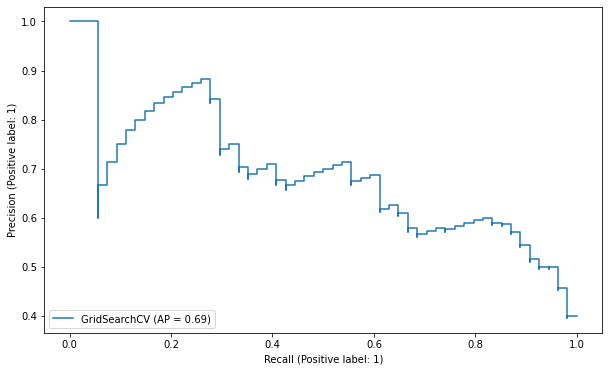

In [54]:
plot_precision_recall_curve(grid_model, X_test, y_test);

In [57]:
roc_auc_score(y_test, y_pred_proba[:,1])

0.8072222222222222

In [58]:
y_pred_proba_tr = lgb_model.predict_proba(X_train)

In [61]:
precisions, recalls, thresholds = precision_recall_curve(y_train, y_pred_proba_tr[: ,1])
optimal_idx = np.argmax((precisions + recalls)/2)
optimal_threshold = thresholds[optimal_idx]
optimal_threshold

0.6976466849568069

In [62]:
precisions, recalls, thresholds = precision_recall_curve(y_train, y_pred_proba_tr[: ,0])
optimal_idx = np.argmax((precisions + recalls)/2)
optimal_threshold2 = thresholds[optimal_idx]
optimal_threshold2

0.0039188634417298696

In [63]:
optimal_threshold_accuarcy = (optimal_threshold + optimal_threshold2)/2
optimal_threshold_accuarcy

0.3507827741992684

In [69]:
y_pred = pd.Series(grid_model.predict_proba(X_test)[:,1]).apply(lambda x : 1 if x >= optimal_threshold_accuarcy else 0)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[71 29]
 [16 38]]
              precision    recall  f1-score   support

           0       0.82      0.71      0.76       100
           1       0.57      0.70      0.63        54

    accuracy                           0.71       154
   macro avg       0.69      0.71      0.69       154
weighted avg       0.73      0.71      0.71       154



In [72]:
y_pred = pd.Series(grid_model.predict_proba(X_train)[:,1]).apply(lambda x : 1 if x >= optimal_threshold_accuarcy else 0)

print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred))

[[325  75]
 [ 35 179]]
              precision    recall  f1-score   support

           0       0.90      0.81      0.86       400
           1       0.70      0.84      0.76       214

    accuracy                           0.82       614
   macro avg       0.80      0.82      0.81       614
weighted avg       0.83      0.82      0.82       614

